**For assumption evaluation, most assumptions aren't violated except for normal residual distribution, homoscedasticity and multicolinearity**

In [2]:
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np
import warnings
warnings.simplefilter('ignore')
from sklearn.model_selection import train_test_split
from statsmodels.regression.linear_model import OLS
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_log_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant 
from scipy.stats import probplot
from statsmodels.stats.diagnostic import het_breuschpagan
from scipy.stats import jarque_bera

In [3]:
def dfSplitter(df):
    y=df['count']
    X=df.iloc[:, :10]
    xTrain, xTest, yTrain, yTest=train_test_split(X, y, train_size=0.8, random_state=42)
    return(xTrain, xTest, yTrain, yTest)

In [4]:
def cleanerX(X1):
    '''
    Add 4 columns into data frame: month, day, hour and name of day 
    '''
    X=X1.copy()
    X['month']=X.index.month
    X['day']=X.index.weekday
    X['hour']=X.index.hour
    X['dayName']=X.index.day_name()
    return X

In [5]:
def featEng(X):
    '''
    Creates new features based on EDA and feature selection to optimize model
    '''
    X['mJun']=np.abs(X['month']-6) 
    X['mJul']=np.abs(X['month']-7)
    X['8h']=np.abs(X['hour']-8)
    X['18h']=np.abs(X['hour']-18)
    X['mJulHol']=X['mJul']*X['holiday']
    X['mJunWD']=X['mJun']*X['workingday']
    X['mJultemp']=X['mJul']*X['temp']
    X['mJulHum']=X['mJul']*X['humidity']
    return(X)

In [6]:
def featEng2(X,y):
    '''
    Cleans up the data for modeling 
    '''
    X.drop(['dayName', 'casual', 'registered'], axis=1, inplace=True)
    y=np.log1p(y+1)
    return(X,y)

In [7]:
bikes=pd.read_csv('train.csv', index_col=0, parse_dates=True)

In [9]:
xTrain, xTest, yTrain, yTest=dfSplitter(bikes)
xTrain=cleanerX(xTrain)
xTrain, yTrain=featEng2(xTrain, yTrain)
xTrain=featEng(xTrain)

In [10]:
xTrain=xTrain[['hour','atemp','humidity','month','workingday','holiday','mJulHol','mJunWD','mJultemp','mJulHum', '8h', '18h']]

In [11]:
df=pd.concat([yTrain, xTrain], axis=1)

### I. Linear Relationship 

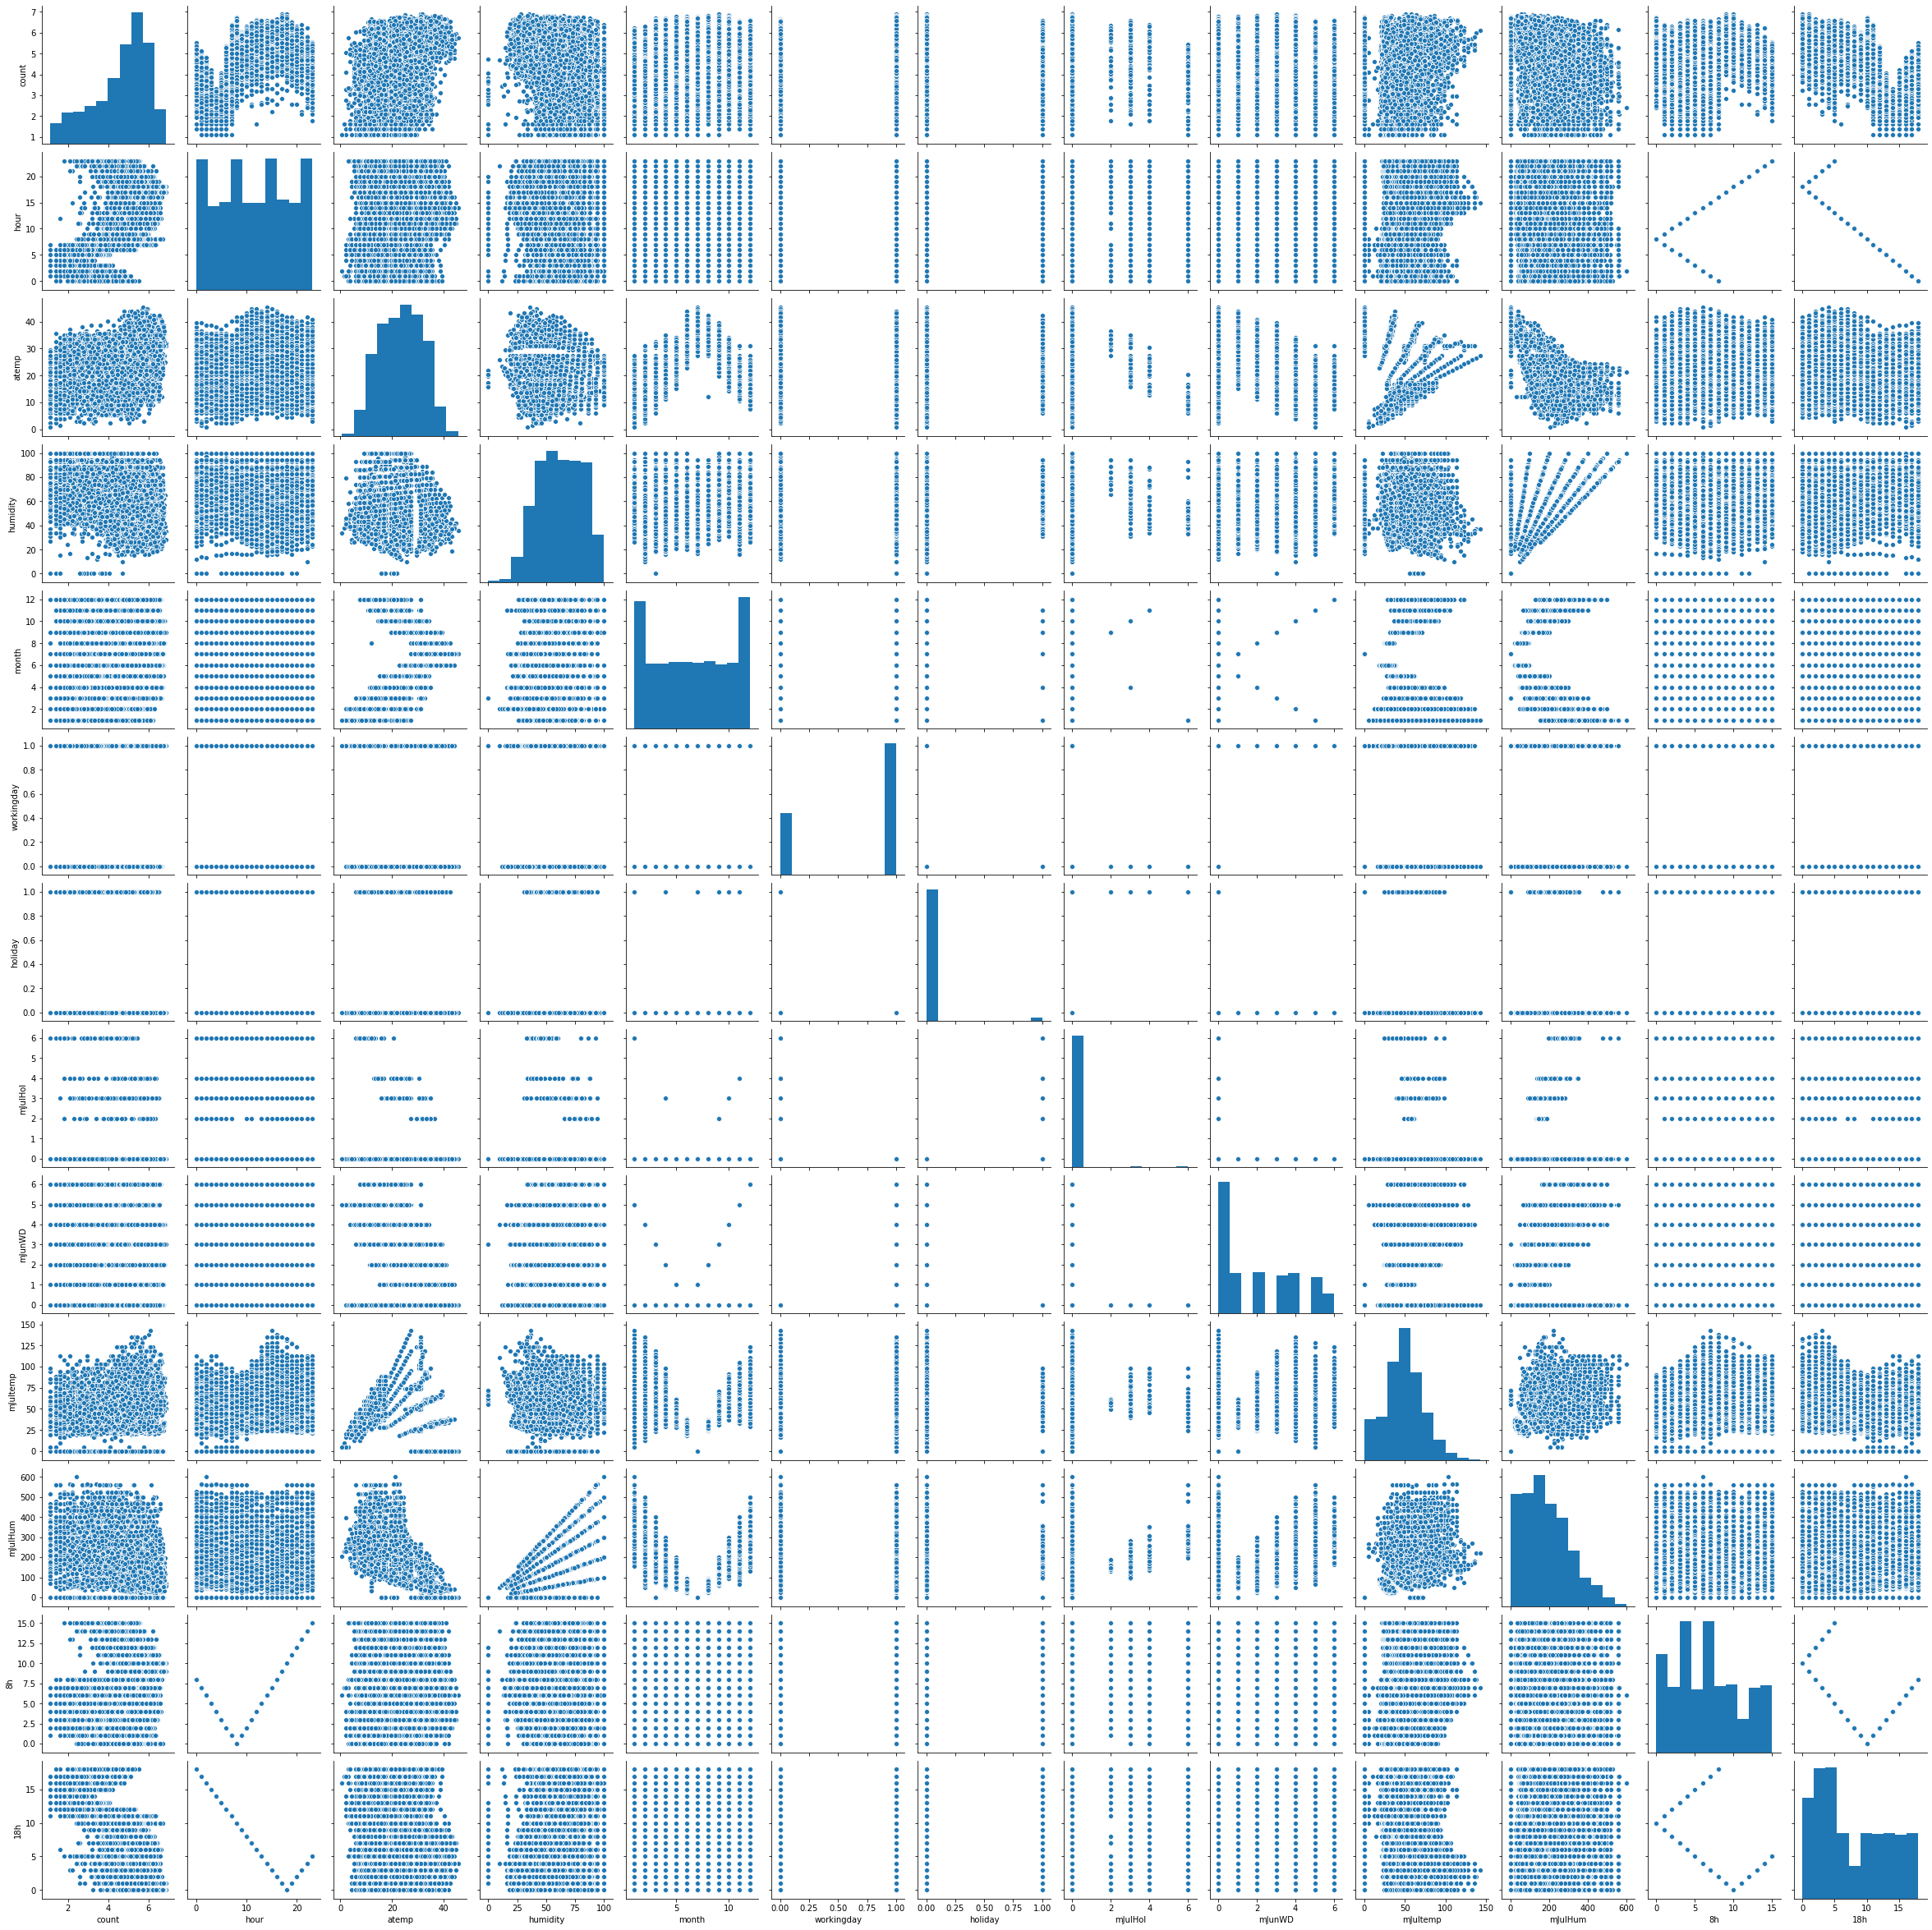

In [12]:
sns.pairplot(df)

### III. Sample variation in all independent features

In [13]:
df.nunique()

count         800
hour           24
atemp          60
humidity       88
month          12
workingday      2
holiday         2
mJulHol         5
mJunWD          7
mJultemp      108
mJulHum       279
8h             16
18h            19
dtype: int64

### IV. Zero Conditional Mean: $E(\epsilon|X)=0$

In [14]:
m=LinearRegression()
m.fit(df.drop('count', axis=1), df['count'])
df['ypred']=m.predict(df.drop('count', axis=1))
df['resids']=df['count']-df['ypred']

In [15]:
df.cov().iloc[-1:,:].transpose()

,resids
count,7.008450e-01
hour,1.666393e-14
atemp,1.216989e-14
humidity,-1.874162e-14
month,-2.634851e-16
workingday,-7.242525e-18
holiday,-7.746187e-18
mJulHol,-1.083829e-16
mJunWD,-2.251915e-15
mJultemp,-4.205316e-14


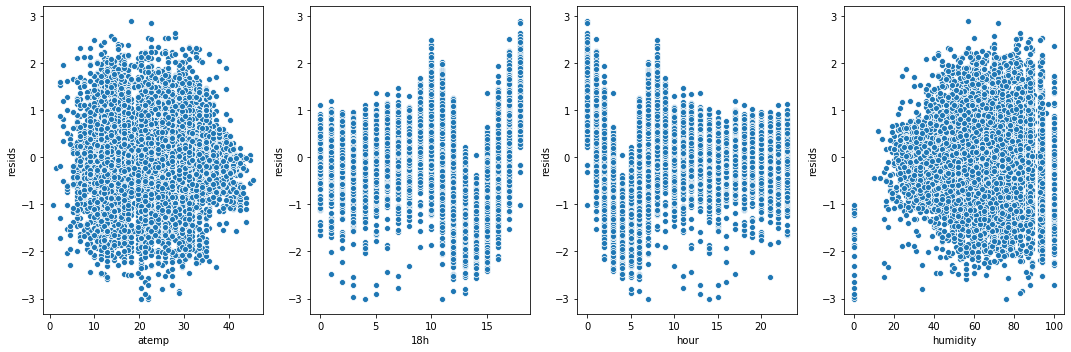

In [16]:
fig, g=plt.subplots(1,4, figsize=(15,5))
sns.scatterplot(x='atemp', y='resids', data=df, ax=g[0])
sns.scatterplot(x='18h', y='resids', data=df, ax=g[1])
sns.scatterplot(x='hour', y='resids', data=df, ax=g[2])
sns.scatterplot(x='humidity', y='resids', data=df, ax=g[3])
plt.tight_layout()

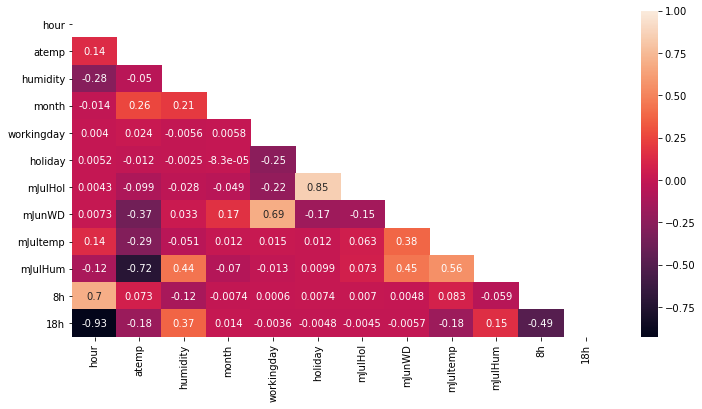

In [17]:
plt.figure(figsize=(12, 6))
corr=xTrain.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr, annot=True, mask=mask)

### V. Homoscedasticity

In [21]:
het_breuschpagan(df['resids'], df.drop('count', axis=1))

(2123.3877998785865, 0.0, 215.6628792084957, 0.0)

### VI. Normally distributed Residuals 

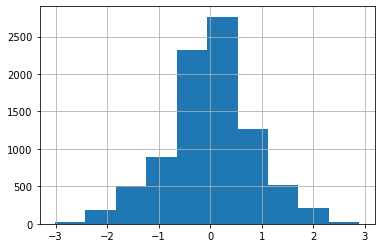

In [22]:
df['resids'].hist()

((array([-3.77627465, -3.5491955 , -3.42443716, ...,  3.42443716,
          3.5491955 ,  3.77627465]),
  array([-3.01603046, -3.01373997, -2.96354455, ...,  2.63328484,
          2.84995011,  2.89528715])),
 (0.8337042791514689, -1.1489665605568155e-15, 0.9955198316803597))

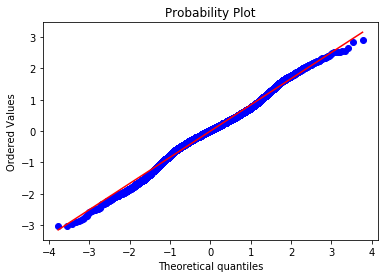

In [23]:
probplot(df['resids'], plot=plt)

In [24]:
jarque_bera(df['resids'])

(97.1914615184691, 0.0)

### VII. Multicolinearity

In [18]:
df['w0']=1
m=OLS(df['count'], df.drop('count', axis=1))
resultM=m.fit()
resultM.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  count   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 3.901e+30
Date:                Sun, 16 Aug 2020   Prob (F-statistic):               0.00
Time:                        20:33:53   Log-Likelihood:             2.6330e+05
No. Observations:                8708   AIC:                        -5.266e+05
Df Residuals:                    8694   BIC:                        -5.265e+05
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
hour           0.0009   1.22e-16    7.4e+12      0.000       0.001       0.001
atemp          0.0010   5.06e-17   2.05e+13      0.000       0.001       0.001
humidity      -0.0002   1.75e-17  -1.41e+13      0.000      -0.000      -0.000
month          0.0018    7.2e-17   2.43e+13      0.000       0.002       0.002
workingday    -0.0010   7.42e-16  -1.32e+12      0.000      -0.001      -0.001
holiday        0.0002   2.25e-15   1.03e+11      0.000       0.000       0.000
mJulHol       -0.0009   5.91e-16  -1.48e+12      0.000      -0.001      -0.001
mJunWD        -0.0004   2.05e-16   -1.9e+12      0.000      -0.000      -0.000
mJultemp     8.32e-05   1.23e-17   6.78e+12      0.000    8.32e-05    8.32e-05
mJulHum    -1.023e-05   4.15e-18  -2.46e+12      0.000   -1.02e-05   -1.02e-05
8h            -0.0032   1.02e-16  -3.16e+13      0.000      -0.003      -0.003
18h           -0.0050   7.83e-17  -6.39e+13      0.000      -0.005      -0.005
ypred          0.9680      4e-16   2.42e+15      0.000       0.968       0.968
resids         1.0000   2.29e-16   4.37e+15      0.000       1.000       1.000
w0             0.1759   7.39e-17   2.38e+15      0.000       0.176       0.176
==============================================================================
Omnibus:                       97.466   Durbin-Watson:                   1.221
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              118.885
Skew:                           0.188   Prob(JB):                     1.53e-26
Kurtosis:                       3.431   Cond. No.                     5.23e+17
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.73e-27. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [19]:
xTrain=add_constant(xTrain)
VIF=pd.DataFrame([variance_inflation_factor(xTrain.values, i) for i in range(xTrain.shape[1])], index=xTrain.columns)
display(VIF)

,0
const,140.767078
hour,16.483069
atemp,3.665535
humidity,2.826972
month,1.473112
workingday,3.262166
holiday,3.917399
mJulHol,3.925040
mJunWD,4.628158
mJultemp,2.294259


In [20]:
xTrain2=xTrain.drop('hour', axis=1, inplace=True)
xTrain2=add_constant(xTrain)
VIF=pd.DataFrame([variance_inflation_factor(xTrain2.values, i) for i in range(xTrain2.shape[1])], index=xTrain2.columns)
display(VIF)

,0
const,47.801283
atemp,3.605517
humidity,2.744895
month,1.473109
workingday,3.262026
holiday,3.917317
mJulHol,3.924913
mJunWD,4.628157
mJultemp,2.277859
mJulHum,7.199511
